In [18]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers

import pathlib
import glob

In [19]:


data_dir_train = pathlib.Path("/orange/pinaki.sarder/ahmed.naglah/codes/dsa_annotation_overlay/outs/vit_exp01/train/")
data_dir_test = pathlib.Path("/orange/pinaki.sarder/ahmed.naglah/codes/dsa_annotation_overlay/outs/vit_exp01/val/")

data_dir_train = pathlib.Path("/orange/pinaki.sarder/ahmed.naglah/codes/10xVisiumChromiumDN/data/classification_experiments/exper11/train/")
data_dir_test = pathlib.Path("/orange/pinaki.sarder/ahmed.naglah/codes/10xVisiumChromiumDN/data/classification_experiments/exper11/val/")

train_count = len(list(data_dir_train.glob('*/*.jpg')))
print(train_count)

test_count = len(list(data_dir_test.glob('*/*.jpg')))
print(test_count)

2706
2706


In [20]:
batch_size = 16
img_height = 224
img_width = 224

training_data = tf.keras.utils.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.1,
  subset="training",
  label_mode="categorical",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

validation_data = tf.keras.utils.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.1,
  subset="validation",
  label_mode="categorical",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

test_data = tf.keras.utils.image_dataset_from_directory(
  data_dir_test,
  label_mode="categorical",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2706 files belonging to 2 classes.
Using 2436 files for training.
Found 2706 files belonging to 2 classes.
Using 270 files for validation.
Found 2706 files belonging to 2 classes.


In [21]:
batch_size = 25
img_height = 224
img_width = 224

training_data = tf.keras.utils.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.1,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

validation_data = tf.keras.utils.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.1,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

test_data = tf.keras.utils.image_dataset_from_directory(
  data_dir_test,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2706 files belonging to 2 classes.
Using 2436 files for training.
Found 2706 files belonging to 2 classes.
Using 270 files for validation.
Found 2706 files belonging to 2 classes.


['negative', 'positive']


2023-08-25 10:10:08.484296: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 60 of 200
2023-08-25 10:10:17.330395: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


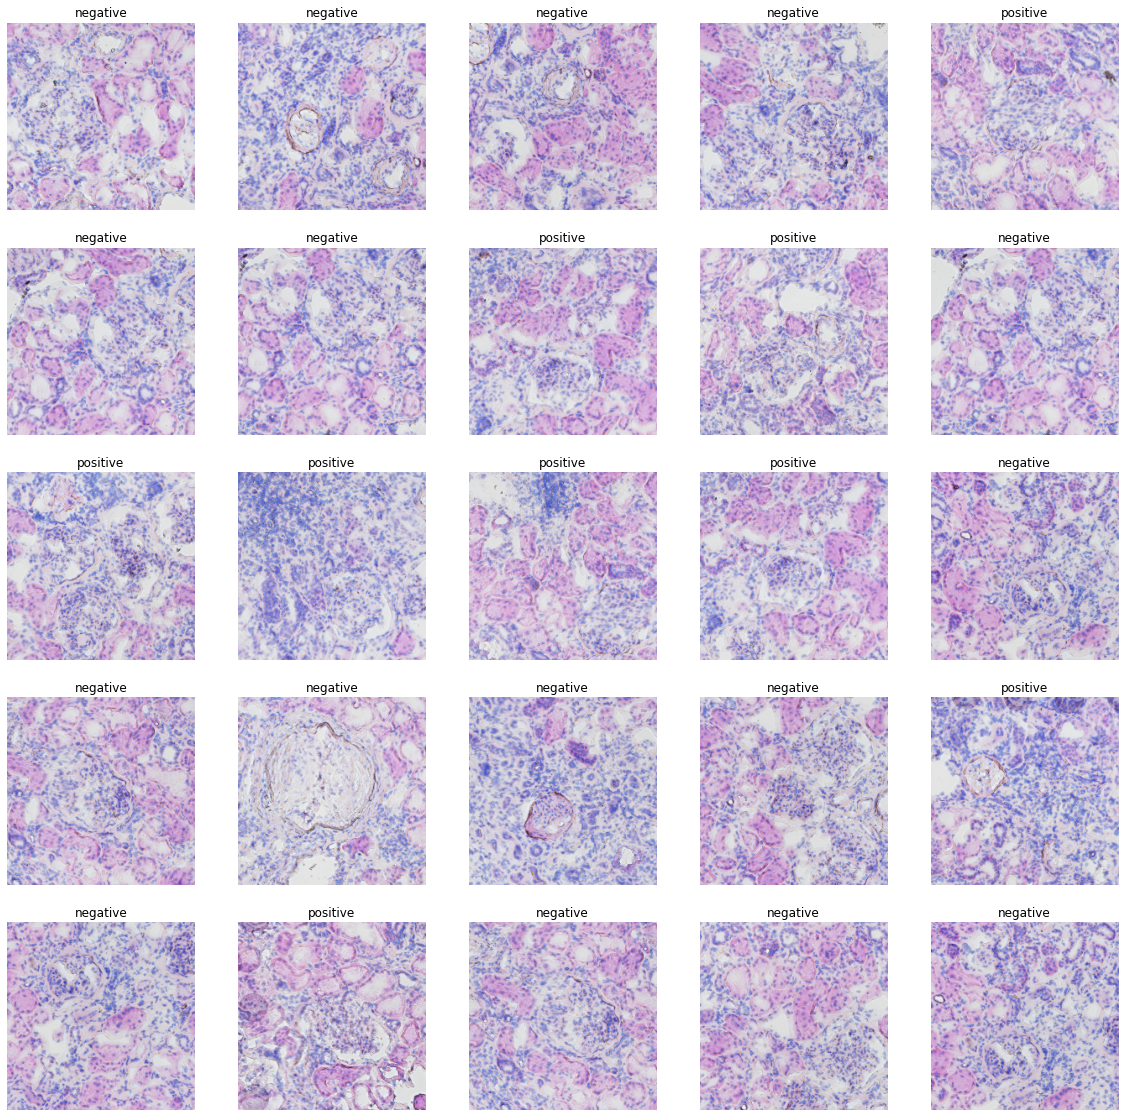

In [22]:
import matplotlib.pyplot as plt

class_names = training_data.class_names
print(class_names)

plt.figure(figsize=(20, 20))
for images, labels in training_data.take(1):
    for i in range(25):
        ax = plt.subplot(5, 5, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [23]:
class generate_patch(layers.Layer):
    def __init__(self, patch_size):
        super(generate_patch, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(images=images, 
                                           sizes=[1, self.patch_size, self.patch_size, 1], 
                                           strides=[1, self.patch_size, self.patch_size, 1], rates=[1, 1, 1, 1], padding="VALID")
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims]) #here shape is (batch_size, num_patches, patch_h*patch_w*c) 
        return patches

check shapes:  (1, 224, 224, 3)
patch per image and patches shape:  49 
 (1, 49, 3072)


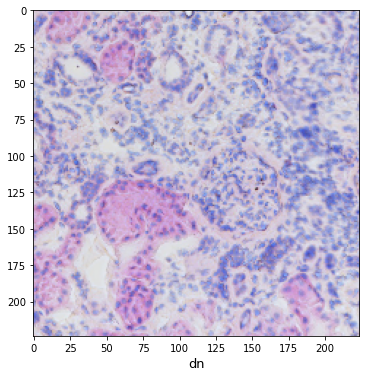

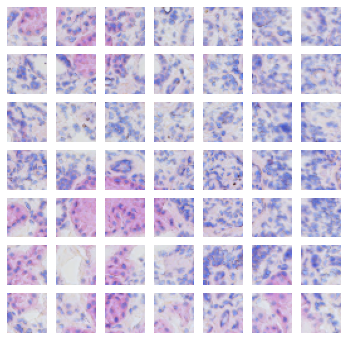

In [24]:
from itertools import islice, count

class_types = ['dn', 'normal']
train_batch0 = next(islice(training_data, 0, None)) # access the 7th element from the iterator
train_iter_7im = train_batch0[0][7,:,:,:]
train_iter_7label = train_batch0[1][7]
train_iter_7im = tf.expand_dims(train_iter_7im, 0)
train_iter_7label = train_iter_7label.numpy()

print('check shapes: ', train_iter_7im.shape) 

patch_size= 32
generate_patch_layer = generate_patch(patch_size=patch_size)
patches = generate_patch_layer(train_iter_7im)

print ('patch per image and patches shape: ', patches.shape[1], '\n', patches.shape)

def render_image_and_patches(image, patches):
    plt.figure(figsize=(6, 6))
    plt.imshow(tf.cast(image[0], tf.uint8))
    plt.xlabel(class_types [np.argmax(train_iter_7label)], fontsize=13)
    n = int(np.sqrt(patches.shape[1]))
    plt.figure(figsize=(6, 6))
    #plt.suptitle(f"Image Patches", size=13)
    for i, patch in enumerate(patches[0]):
        ax = plt.subplot(n, n, i+1)
        patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
        ax.imshow(patch_img.numpy().astype("uint8"))
        ax.axis('off')    

render_image_and_patches(train_iter_7im, patches)

In [25]:
class PatchEncode_Embed(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncode_Embed, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim) # activation = linear
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim)

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

In [26]:
patch_encoder = PatchEncode_Embed(49, 49)(patches)
print (tf.shape(patch_encoder))

tf.Tensor([ 1 49 49], shape=(3,), dtype=int32)


In [27]:
class generate_patch_conv(layers.Layer):
    def __init__(self, patch_size):
        super(generate_patch_conv, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = layers.Conv2D(self.patch_size*self.patch_size*3, self.patch_size, self.patch_size, padding='valid')(images)

        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches  

class generate_patch_conv_orgPaper(layers.Layer):

    def __init__(self, patch_size, hidden_size):
        super(generate_patch_conv_orgPaper, self).__init__()
        self.patch_size = patch_size
        self.hidden_size = hidden_size

    def call(self, images):
        patches = layers.Conv2D(self.hidden_size, self.patch_size, self.patch_size, padding='valid', name='Embedding')(images) 
        rows_axis, cols_axis = (1, 2) 
        seq_len = (images.shape[rows_axis] // patch_size) * (images.shape[cols_axis] // patch_size)
        x = tf.reshape(patches, [-1, seq_len, self.hidden_size])
        return x

def generate_patch_conv_orgPaper_f(patch_size, hidden_size, inputs):
    patches = layers.Conv2D(filters=hidden_size, kernel_size=patch_size, strides=patch_size, padding='valid')(inputs)
    row_axis, col_axis = (1, 2) # channels last images
    seq_len = (inputs.shape[row_axis] // patch_size) * (inputs.shape[col_axis] // patch_size)
    x = tf.reshape(patches, [-1, seq_len, hidden_size])
    return x

train_iter_7im = tf.cast(train_iter_7im, dtype=tf.float16)
generate_patch_conv_layer = generate_patch_conv(patch_size=patch_size)
patches_conv = generate_patch_conv_layer(train_iter_7im)


print ('patch per image and patches shape: ', patches_conv.shape[1], '\n', patches_conv.shape)    

generate_patch_conv_orgPaper_layer = generate_patch_conv_orgPaper(patch_size=patch_size, hidden_size=64)
patches_conv_org = generate_patch_conv_orgPaper_layer(train_iter_7im)

hidden_size=64
patches_conv_org_f = generate_patch_conv_orgPaper_f(patch_size, hidden_size, train_iter_7im)

print ('patch per image and patches shape: ', patches_conv_org.shape[1], '\n', patches_conv_org.shape)
print ('patch per image and patches shape: ', patches_conv_org_f.shape[1], '\n', patches_conv_org_f.shape)

patch per image and patches shape:  49 
 (1, 49, 3072)
patch per image and patches shape:  49 
 (1, 49, 64)
patch per image and patches shape:  49 
 (1, 49, 64)


In [28]:
class AddPositionEmbs(layers.Layer):

    def __init__(self, posemb_init=None, **kwargs):
        super().__init__(**kwargs)
        self.posemb_init = posemb_init

    def build(self, inputs_shape):
        pos_emb_shape = (1, inputs_shape[1], inputs_shape[2])
        self.pos_embedding = self.add_weight('pos_embedding', pos_emb_shape, initializer=self.posemb_init)

    def call(self, inputs, inputs_positions=None):
        pos_embedding = tf.cast(self.pos_embedding, inputs.dtype)
        return inputs + pos_embedding

pos_embed_layer = AddPositionEmbs(posemb_init=tf.keras.initializers.RandomNormal(stddev=0.02))
embedded_inp = pos_embed_layer(patches_conv_org)

print ('embedded input shape: ', embedded_inp.shape)

embedded input shape:  (1, 49, 64)


In [29]:
def mlp_block_f(mlp_dim, inputs):
    x = layers.Dense(units=mlp_dim, activation=tf.nn.gelu)(inputs)
    x = layers.Dropout(rate=0)(x) # dropout rate is from original paper,
    x = layers.Dense(units=inputs.shape[-1], activation=tf.nn.gelu)(x)
    x = layers.Dropout(rate=0)(x)
    return x

def Encoder1Dblock_f(num_heads, mlp_dim, inputs):
    x = layers.LayerNormalization(dtype=inputs.dtype)(inputs)
    x = layers.MultiHeadAttention(num_heads=num_heads, key_dim=inputs.shape[-1], dropout=0.1)(x, x) # self attention multi-head, dropout_rate is from original implementation
    x = layers.Add()([x, inputs]) # 1st residual part 
    y = layers.LayerNormalization(dtype=x.dtype)(x)
    y = mlp_block_f(mlp_dim, y)
    y_1 = layers.Add()([y, x]) #2nd residual part 
    return y_1


Encoder1Dblock_layer_out_f = Encoder1Dblock_f(4, 32, embedded_inp)

print ('output shape of Encoder block when inputs are the embeddings: ', Encoder1Dblock_layer_out_f.shape)

output shape of Encoder block when inputs are the embeddings:  (1, 49, 64)


In [30]:
autotune = tf.data.AUTOTUNE 


rescale_layer = tf.keras.Sequential([layers.experimental.preprocessing.Rescaling(1./255)])

data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2), 
  layers.experimental.preprocessing.RandomZoom(height_factor=(0.2, 0.3), width_factor=(0.2, 0.3)),
  layers.experimental.preprocessing.RandomTranslation(0.3, 0.3, fill_mode='reflect', interpolation='bilinear',)
])


train_ds = (training_data.shuffle(40000).map(lambda x, y: (data_augmentation(x), y), num_parallel_calls=autotune).prefetch(autotune))
valid_ds = (validation_data.shuffle(10000).prefetch(autotune))

In [31]:
def Encoder_f(num_layers, mlp_dim, num_heads, inputs):
    x = AddPositionEmbs(posemb_init=tf.keras.initializers.RandomNormal(stddev=0.02), name='posembed_input')(inputs)
    x = layers.Dropout(rate=0.2)(x)
    for _ in range(num_layers):
        x = Encoder1Dblock_f(num_heads, mlp_dim, x)
    encoded = layers.LayerNormalization(name='encoder_norm')(x)
    return encoded

transformer_layers = 6
patch_size = 32
hidden_size = 49
num_heads = 4
mlp_dim = 128

train_im_shape = (32, 224, 224, 3)

def build_ViT():
    inputs = layers.Input(shape=train_im_shape[1:])
    rescale = rescale_layer(inputs)
    patches = generate_patch_conv_orgPaper_f(patch_size, hidden_size, rescale)
    encoder_out = Encoder_f(transformer_layers, mlp_dim, num_heads, patches)  
    im_representation = tf.reduce_mean(encoder_out, axis=1)  # (1,) or (1,2)
    logits = layers.Dense(units=len(class_types), name='head', kernel_initializer=tf.keras.initializers.zeros)(im_representation) # !!! important !!! activation is linear 
    final_model = tf.keras.Model(inputs = inputs, outputs = logits)
    return final_model

ViT_model = build_ViT()
ViT_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
sequential_2 (Sequential)       (None, 224, 224, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 7, 7, 49)     150577      sequential_2[0][0]               
__________________________________________________________________________________________________
tf.reshape_1 (TFOpLambda)       (None, 49, 49)       0           conv2d_5[0][0]                   
____________________________________________________________________________________________

In [32]:
batch_size = 25
img_height = 224
img_width = 224

training_data = tf.keras.utils.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.1,
  subset="training",
  label_mode="categorical",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

validation_data = tf.keras.utils.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.1,
  subset="validation",
  label_mode="categorical",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

test_data = tf.keras.utils.image_dataset_from_directory(
  data_dir_test,
  label_mode="categorical",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2706 files belonging to 2 classes.
Using 2436 files for training.
Found 2706 files belonging to 2 classes.
Using 270 files for validation.
Found 2706 files belonging to 2 classes.


In [34]:
ViT_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-3), 
                  loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True), 
                  metrics=[tf.keras.metrics.CategoricalAccuracy(name="accuracy"), tf.keras.metrics.TopKCategoricalAccuracy(k=5, name='top5 acc')]) 

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.8,
                              patience=5, min_lr=1e-5, verbose=1)

es = tf.keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=1e-6, patience=10, verbose=0, 
                                      mode="auto", baseline=None,restore_best_weights=False)

ViT_Train = ViT_model.fit(training_data, 
                        epochs = 200, 
                        validation_data=test_data, callbacks=[reduce_lr])

Epoch 1/200
98/98 [==============================] - 221s 2s/step - loss: 0.6960 - accuracy: 0.5185 - top5 acc: 1.0000 - val_loss: 0.6930 - val_accuracy: 0.5152 - val_top5 acc: 1.0000
Epoch 2/200
98/98 [==============================] - 35s 345ms/step - loss: 0.6961 - accuracy: 0.4910 - top5 acc: 1.0000 - val_loss: 0.6931 - val_accuracy: 0.5152 - val_top5 acc: 1.0000
Epoch 3/200
98/98 [==============================] - 35s 343ms/step - loss: 0.6959 - accuracy: 0.4893 - top5 acc: 1.0000 - val_loss: 0.6927 - val_accuracy: 0.5152 - val_top5 acc: 1.0000
Epoch 4/200
98/98 [==============================] - 35s 344ms/step - loss: 0.6939 - accuracy: 0.5033 - top5 acc: 1.0000 - val_loss: 0.6962 - val_accuracy: 0.5152 - val_top5 acc: 1.0000
Epoch 5/200
98/98 [==============================] - 35s 344ms/step - loss: 0.6943 - accuracy: 0.5037 - top5 acc: 1.0000 - val_loss: 0.6927 - val_accuracy: 0.5152 - val_top5 acc: 1.0000
Epoch 6/200
98/98 [==============================] - 35s 344ms/step - lo

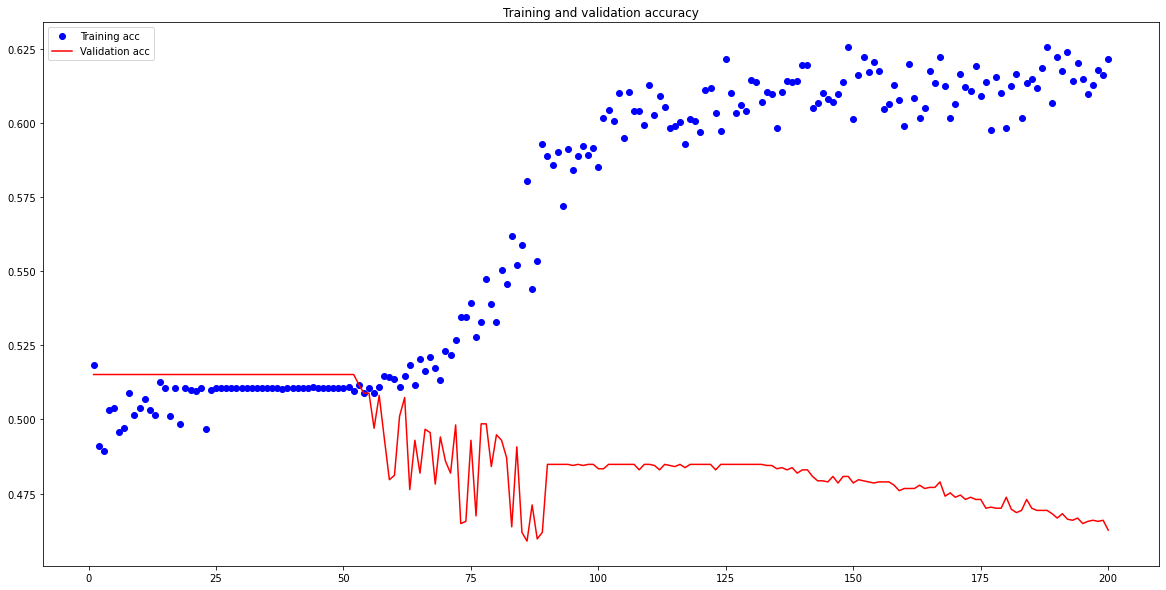

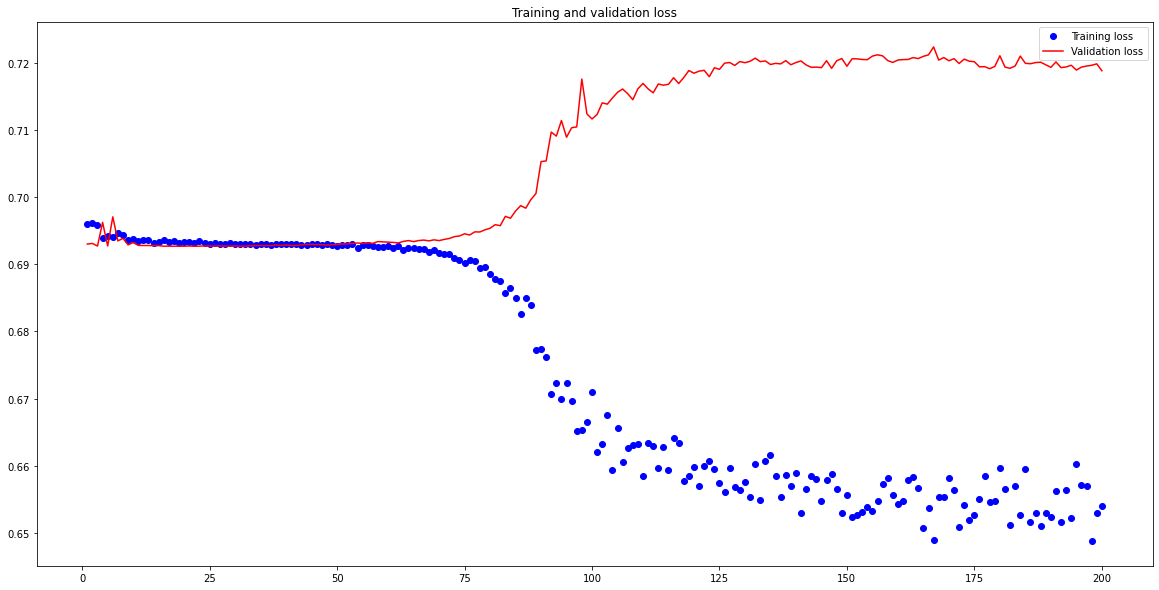

In [35]:
import matplotlib.pyplot as plt

acc = ViT_Train.history['accuracy']
val_acc = ViT_Train.history['val_accuracy']
loss = ViT_Train.history['loss']
val_loss = ViT_Train.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(20,10))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure(figsize=(20,10))

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [48]:
from baselines.ViT.ViT_explanation_generator import LRP
attribution_generator = LRP(model)


def generate_visualization(original_image, class_index=None):
    transformer_attribution = attribution_generator.generate_LRP(original_image.unsqueeze(0).cuda(), method="transformer_attribution", index=class_index).detach()
    transformer_attribution = transformer_attribution.reshape(1, 1, 14, 14)
    transformer_attribution = torch.nn.functional.interpolate(transformer_attribution, scale_factor=16, mode='bilinear')
    transformer_attribution = transformer_attribution.reshape(224, 224).data.cpu().numpy()
    transformer_attribution = (transformer_attribution - transformer_attribution.min()) / (transformer_attribution.max() - transformer_attribution.min())

    if use_thresholding:
      transformer_attribution = transformer_attribution * 255
      transformer_attribution = transformer_attribution.astype(np.uint8)
      ret, transformer_attribution = cv2.threshold(transformer_attribution, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
      transformer_attribution[transformer_attribution == 255] = 1

    image_transformer_attribution = original_image.permute(1, 2, 0).data.cpu().numpy()
    image_transformer_attribution = (image_transformer_attribution - image_transformer_attribution.min()) / (image_transformer_attribution.max() - image_transformer_attribution.min())
    vis = show_cam_on_image(image_transformer_attribution, transformer_attribution)
    vis =  np.uint8(255 * vis)
    vis = cv2.cvtColor(np.array(vis), cv2.COLOR_RGB2BGR)
    return vis


ModuleNotFoundError: No module named 'baselines'

In [46]:
im = generate_visualization(train_iter_7im)

NameError: name 'attribution_generator' is not defined

In [44]:
train_batch0 = next(islice(training_data, 0, None)) # access the 7th element from the iterator

train_iter_7im = train_batch0[0][7,:,:,:]

train_iter_7label = train_batch0[1][7]

In [42]:
train_iter_7im, train_iter_7label = next(islice(training_data, 1, None)) # access the 7th element from the iterator



train_iter_7im = tf.expand_dims(train_iter_7im, 0)
train_iter_7label = train_iter_7label.numpy()

In [45]:
train_iter_7im

<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
array([[[136., 105., 147.],
        [115.,  83., 132.],
        [143., 112., 171.],
        ...,
        [188., 106., 190.],
        [216., 127., 209.],
        [204., 109., 191.]],

       [[130., 102., 140.],
        [127., 100., 143.],
        [183., 154., 208.],
        ...,
        [139.,  57., 139.],
        [171.,  82., 162.],
        [198., 105., 185.]],

       [[143., 123., 150.],
        [144., 123., 156.],
        [208., 187., 230.],
        ...,
        [126.,  45., 122.],
        [148.,  62., 137.],
        [182.,  92., 166.]],

       ...,

       [[190., 174., 200.],
        [184., 168., 194.],
        [187., 166., 197.],
        ...,
        [241., 242., 244.],
        [241., 242., 244.],
        [238., 242., 243.]],

       [[177., 163., 188.],
        [178., 162., 189.],
        [162., 141., 174.],
        ...,
        [235., 244., 243.],
        [233., 243., 244.],
        [230., 242., 242.]],

       [[145., 13